In [ ]:
# TODO: cross validation method 

In [ ]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 104.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
! unzip -o drive/MyDrive/PROJECTS/RSNA/data/rsna256.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: rsna256/14/10837_428532526.png  
  inflating: __MACOSX/rsna256/14/._10837_428532526.png  
  inflating: rsna256/14/15760_1529224901.png  
  inflating: __MACOSX/rsna256/14/._15760_1529224901.png  
  inflating: rsna256/14/32779_399919633.png  
  inflating: __MACOSX/rsna256/14/._32779_399919633.png  
  inflating: rsna256/14/21296_1915144262.png  
  inflating: __MACOSX/rsna256/14/._21296_1915144262.png  
  inflating: rsna256/14/38504_1975291988.png  
  inflating: __MACOSX/rsna256/14/._38504_1975291988.png  
  inflating: rsna256/14/53169_73891292.png  
  inflating: __MACOSX/rsna256/14/._53169_73891292.png  
  inflating: rsna256/14/43725_1926632510.png  
  inflating: __MACOSX/rsna256/14/._43725_1926632510.png  
  inflating: rsna256/14/60862_508875553.png  
  inflating: __MACOSX/rsna256/14/._60862_508875553.png  
  inflating: rsna256/14/52065_913003812.png  
  inflating: __MACOSX/rsna256/14/._52065_91300

In [ ]:
from transformers import AutoFeatureExtractor, Swinv2ForImageClassification
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from PIL import Image
import math
import numpy as np
from tqdm import tqdm
import time
import os 
from glob import glob
import shutil
import matplotlib.pyplot as plt
import random
from math import log
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.special import softmax
from sklearn.utils import class_weight

torch.cuda.empty_cache()

In [ ]:
start_epoch = 92
epochs = 780
batch_size = 32
lr = 1e-7
weight_decay = 1e-8
num_workers = 4

last_model = 'swinv2-tiny-256-0.04108-91'
extractor_path = 'microsoft/swinv2-tiny-patch4-window16-256'
# model_path = 'microsoft/swinv2-tiny-patch4-window16-256'
model_path = f'drive/MyDrive/PROJECTS/RSNA/training/model/{last_model}'
scheduler_path = f'drive/MyDrive/PROJECTS/RSNA/training/scheduler/{last_model}'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor = AutoFeatureExtractor.from_pretrained(extractor_path)
model = Swinv2ForImageClassification.from_pretrained(model_path, num_labels=2, ignore_mismatched_sizes=True).to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

/usr/local/lib/python3.8/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
data_path = 'drive/MyDrive/PROJECTS/RSNA/data/'
rsna_path = 'rsna256/'

rsna_df = pd.DataFrame()
rsna_df['file_path'] = [y for x in os.walk(rsna_path) for y in glob(os.path.join(x[0], '*.png'))]
rsna_df['file_name'] = rsna_df['file_path'].apply(lambda x: x.split('/')[-1].split('.')[0])
data = pd.read_csv(data_path + 'rsna.csv')
data['file_name'] = data['file_name'].apply(lambda x: x.split('.')[0])
data = data.merge(rsna_df, on='file_name')

In [ ]:
X = list(data.file_path)
y = list(data.label)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

In [ ]:
# weighted loss
pos_weight = class_weight.compute_class_weight(class_weight='balanced', classes=[0, 1], y=y_train)
pos_weight = torch.Tensor(pos_weight).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) 

In [ ]:
# label smoothing
y_train = [torch.Tensor([0.9, 0.1]) if y == 0 else torch.Tensor([0.1, 0.9]) for y in y_train]
y_val = [torch.Tensor([0.9, 0.1]) if y == 0 else torch.Tensor([0.1, 0.9]) for y in y_val]

T_max = int(epochs * len(X_train) / batch_size)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)

if scheduler_path is not None:
  scheduler.load_state_dict(torch.load(scheduler_path))

In [ ]:
def RandAugment(image):
  transform = transforms.RandAugment()
  image = transform(image).convert('L')
  return image

def Mixup(image, labels, X, y, alpha=1):
  transform = transforms.ToTensor()
  image = transform(image) # convert to tensor 
  # get a random idx from all the images
  mixup_idx = random.randint(0, len(y)-1)
  # get the image corresponding to the selected image
  mixup_image = Image.open(X[mixup_idx])
  mixup_image = transform(mixup_image) # convert to tensor 
  # update the mixup label
  mixup_labels = y[mixup_idx]

  lam = np.random.beta(alpha, alpha)
  image = lam * image + (1 - lam) * mixup_image
  labels = lam * labels + (1 - lam) * mixup_labels
  transform = transforms.ToPILImage()
  image = transform(image).convert('L') # convert to pillow image
  return image, labels

def rand_bbox(size, lam):
    W = size[1]
    H = size[2]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

def CutMix(image, labels, X, y, alpha=1):
  transform = transforms.ToTensor()
  image = transform(image) # convert to tensor 
  # get a random idx from all the images
  cutmix_idx = random.randint(0, len(y)-1)
  # get the image corresponding to the selected image
  cutmix_image = Image.open(X[cutmix_idx])
  cutmix_image = transform(cutmix_image) # convert to tensor 
  # update the cutmix label
  cutmix_labels = y[cutmix_idx]

  lam = np.random.beta(alpha, alpha)
  bbx1, bby1, bbx2, bby2 = rand_bbox(image.size(), lam)  
  image[:, bby1:bby2, bbx1:bbx2] = cutmix_image[:, bby1:bby2, bbx1:bbx2]
  labels = lam * labels + (1 - lam) * cutmix_labels
  transform = transforms.ToPILImage()
  image = transform(image).convert('L') 
  return image, labels
  
def RandomErasing(image):
  transform = transforms.ToTensor()
  image = transform(image)
  transform = transforms.RandomErasing()
  image = transform(image)
  transform = transforms.ToPILImage()
  image = transform(image).convert('L')
  return image

class CustomDataset(Dataset):
  def __init__(self, X, y, is_train, augmentations):
    self.X = X
    self.y = y
    self.is_train = is_train
    self.augmentations = augmentations
    self.augmentations.append('None')
      
  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    augmentation = random.choice(self.augmentations)
    image = Image.open(self.X[idx])
    labels = self.y[idx]

    if self.is_train and augmentation == 'RandAugment':
      image = RandAugment(image)
    elif self.is_train and augmentation == 'Mixup':
      image, labels = Mixup(image, labels, self.X, self.y)
    elif self.is_train and augmentation == 'CutMix':
      image, labels = CutMix(image, labels, self.X, self.y)
    elif self.is_train and augmentation == 'RandomErasing':
      image = RandomErasing(image)

    image = np.array(image)
    image = np.expand_dims(image, axis=0)
    image = np.concatenate((image, image, image), axis=0)
    item = feature_extractor(image, return_tensors='pt')
    item['pixel_values'] = torch.squeeze(item['pixel_values'])
    item['labels'] = labels

    return item

In [ ]:
augmentations = ['RandAugment', 'Mixup', 'CutMix', 'RandomErasing']
train_dataset = CustomDataset(X_train, y_train, True, augmentations)
val_dataset = CustomDataset(X_val, y_val, False, [])

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)

In [ ]:
def model_training(train_loader, model, optimizer, scheduler):
  train_loss = 0
  model.train()

  for data in tqdm(train_loader):
    optimizer.zero_grad()
    labels = data['labels'].to(device)
    inputs = {key: data[key].to(device) for key in ['pixel_values']}
    outputs = model(**inputs, labels=labels)
    logits = outputs.logits
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()
    scheduler.step()
    train_loss += loss.item()

  train_loss /= len(train_loader)
  return train_loss, model, optimizer, scheduler


def model_validation(val_loader, model):
  val_loss = 0
  val_labels = []
  val_probs = []
  model.eval()

  with torch.no_grad():
    for data in tqdm(val_loader):
      labels = data['labels'].to(device)
      inputs = {key: data[key].to(device) for key in ['pixel_values']}
      outputs = model(**inputs, labels=labels)
      logits = outputs.logits
      loss = criterion(logits, labels)
      probs = softmax(logits[:, 1].cpu())
      val_loss += loss.item()
      val_labels += labels.argmax(-1).tolist()
      val_probs += probs.tolist()

  val_loss /= len(val_loader)
  return val_loss, val_labels, val_probs, model


def pfbeta(labels, predictions, beta=1):
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(predictions[idx], 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    if ctp == 0 and cfp == 0:
      c_precision = 0
    else:
      c_precision = ctp / (ctp + cfp)
      
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0

In [ ]:
def save_training(model, scheduler, val_pf1, epoch):
  save_model_path = 'drive/MyDrive/PROJECTS/RSNA/training/model'
  save_scheduler_path = 'drive/MyDrive/PROJECTS/RSNA/training/scheduler'
  files = [f for f in os.listdir(save_model_path)]

  if len(files) == 1:
    best_model = files[0]
    best_score = float(best_model.split('-')[-2])
  elif len(files) > 1:
    raise 'Too many models in the folder'
  else:
    best_score = 0

  if val_pf1 > best_score:
    if len(files) == 1:
      shutil.rmtree(f'{save_model_path}/{best_model}')
      os.remove(f'{save_scheduler_path}/{best_model}')
      
    model_path = f'{save_model_path}/swinv2-tiny-256-{val_pf1:.5f}-{epoch}'
    model.save_pretrained(model_path)

    scheduler_path = f'{save_scheduler_path}/swinv2-tiny-256-{val_pf1:.5f}-{epoch}'
    torch.save(scheduler.state_dict(), scheduler_path)

============== EPOCH 92/780 ==============


100%|██████████| 171/171 [00:45<00:00,  3.74it/s]


Val preds pF1 = 0.04121



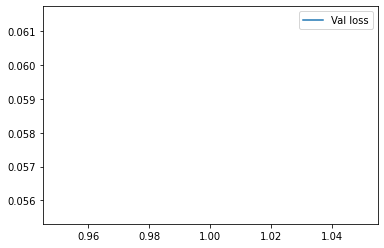




============== EPOCH 93/780 ==============


100%|██████████| 171/171 [00:45<00:00,  3.75it/s]


Val preds pF1 = 0.04077



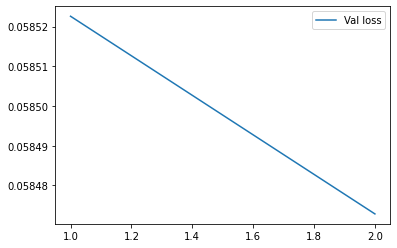




============== EPOCH 94/780 ==============


100%|██████████| 171/171 [00:45<00:00,  3.74it/s]



Val preds pF1 = 0.04073



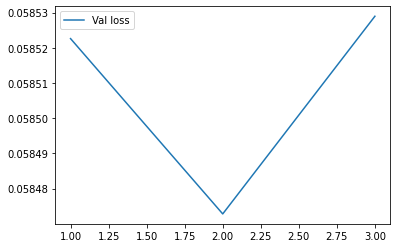




============== EPOCH 95/780 ==============


100%|██████████| 171/171 [00:45<00:00,  3.74it/s]


Val preds pF1 = 0.04174



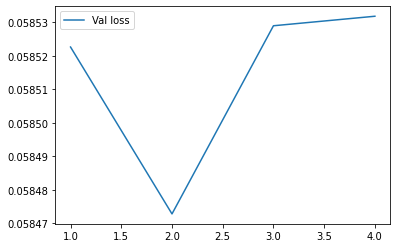




============== EPOCH 96/780 ==============


100%|██████████| 171/171 [00:45<00:00,  3.74it/s]


Val preds pF1 = 0.04124



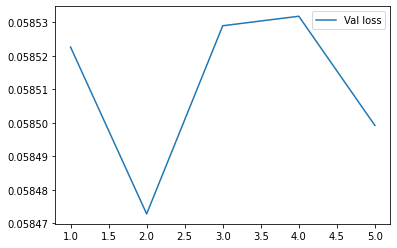




============== EPOCH 97/780 ==============


 56%|█████▌    | 862/1539 [11:00<08:38,  1.30it/s]

In [ ]:
train_losses = []
val_losses = []

for epoch in range(start_epoch, epochs+1):
  print(f'============== EPOCH {epoch}/{epochs} ==============')

  # Train the model
  train_loss, model, optimizer, scheduler = model_training(train_loader, model, optimizer, scheduler)
  train_losses.append(train_loss)

  # Validate the model 
  val_loss, val_labels, val_probs, model = model_validation(val_loader, model)
  val_losses.append(val_loss)
  val_pf1 = pfbeta(val_labels, val_probs, 1)

  # Print epochs metrics
  print(f'\nVal preds pF1 = {val_pf1:.5f}')

  # threshlods = list(np.arange(0.01, 0.11, 0.005))
  # for threshlod in threshlods:
  #   val_preds = [0 if val_prob < threshlod else 1 for val_prob in val_probs]
  #   val_pf1_thrld = pfbeta(val_labels, val_preds, 1)
  #   print(f'{threshlod:.3f} - Val preds pF1 = {val_pf1_thrld:.5f}')
  print()

  # Plot losses
  x = list(range(1, len(val_losses)+1))
  # plt.plot(x, [log(loss, 10) for loss in train_losses], label='Train loss')
  plt.plot(x, [log(loss, 10) for loss in val_losses], label='Val loss')
  plt.legend()
  plt.show()
  print('\n\n')

  # Save the model 
  save_training(model, scheduler, val_pf1, epoch)